# Ground-roll attenuation model

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Inference on a large dataset](#Inference-on-a-large-dataset)
* [Conclusion](#Conclusion)

## Problem description

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. It should be suppressed at initial stage of seismograms processing.

## Dataset

Dataset is given by 2 SEGY files with a seismogram before and after manual ground-roll attenuation according to LIFT procedure. The seismorgam contains 176K traces combined in 51 field records. 

First, we index files, field records and traces:

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import segyio

sys.path.append('..')

from batchflow import Dataset, DatasetIndex, Pipeline, B, V, F
from batchflow.models.tf import UNet

from geolog import SeismicBatch, SegyFilesIndex, FieldIndex, TraceIndex, CustomIndex

%env CUDA_VISIBLE_DEVICES=4

path_raw = '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '../../noise_data/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))

index.head()

env: CUDA_VISIBLE_DEVICES=4


,file_id,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE
,raw,,,raw,lift,lift
FieldRecord,,,,,,
111906,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1656,35,1,../../noise_data/DN02B_SHOTS_LIFT1.sgy,1
111906,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1657,36,2,../../noise_data/DN02B_SHOTS_LIFT1.sgy,2
111906,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1655,78,3,../../noise_data/DN02B_SHOTS_LIFT1.sgy,3
111906,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1658,79,4,../../noise_data/DN02B_SHOTS_LIFT1.sgy,4
111906,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1654,127,5,../../noise_data/DN02B_SHOTS_LIFT1.sgy,5


Select 5 first field records for training subset:

In [47]:
train_index = index.create_subset(index.indices[:5])

Load first field record from training subset:

In [48]:
batch = (Dataset(index, SeismicBatch).next_batch(5)
         .load(components=('raw', 'lift'), sort_by='offset')
        )

Show raw and filtered traces (sorted by offset):

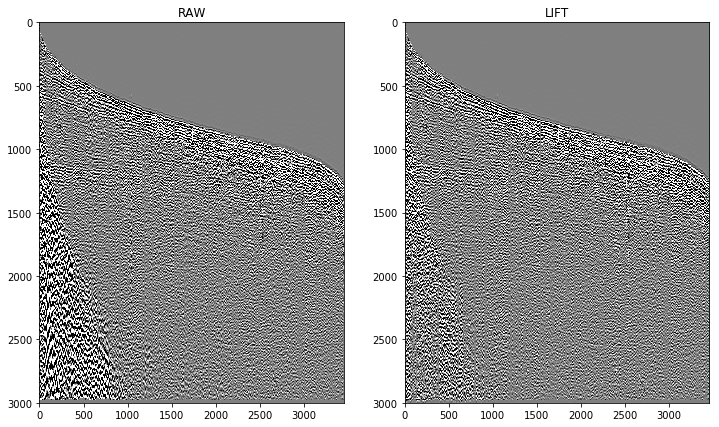

In [49]:
cv = 0.2
i = 0
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(batch.raw[i].T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].imshow(batch.lift[i].T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('RAW')
ax[1].set_title('LIFT')
ax[0].axis('auto'), ax[1].axis('auto')
plt.show()

## Model architecture

We exploit a convolutional neural network of the U-net type with depth 4.
Set the model config:

In [29]:
import tensorflow as tf
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3000, 1)}, 
                   y={'name':'targets', 'shape': (3000, 1)}),
    'body/filters': [8, 16, 32, 64, 128],
    'body/encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'body/decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/upsample': dict(layout='tad', kernel_size=7, strides=2,
                          dropout_rate=0.05, activation=tf.nn.elu),
    'loss':'l1',
    'optimizer': 'Adam'
}

## Training

Reorder traces

In [30]:
train_set = Dataset(TraceIndex(train_index).shuffle(), SeismicBatch)

Set a training pipeline

In [31]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(list(batch.raw), -1),
                          'y': np.expand_dims(list(batch.lift), -1)}}

train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), tslice=np.arange(3000))
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss'), mode='a')
                 )

Run the training pipeline

In [33]:
batch_size = 64

train_pipeline = train_pipeline << train_set
train_pipeline.run(batch_size, n_epochs=3, drop_last=True, shuffle=True, bar=True)

  0%|          | 0/810 [00:00<?, ?it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


100%|█████████▉| 809/810 [01:13<00:00, 10.99it/s]


Loss against iterations:

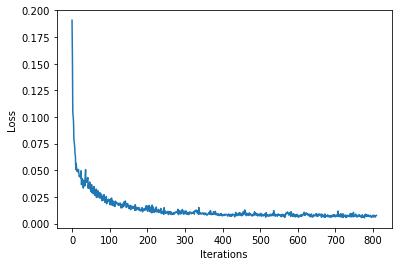

In [34]:
plt.plot(train_pipeline.get_variable("loss"))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

Dump model:

In [26]:
train_pipeline.save_model('unet', './unet_model')

## Inference

Inference pipeline for a quick model estimation:

In [35]:
model_config = {
    "build": False,
    "load": {"path": './unet_model'},
}

def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1)}}

predict_pipeline = (Pipeline()
                    .load(components='raw', tslice=np.arange(3000), sort_by='offset')
                    .import_model('unet', train_pipeline)
#                     .init_model("static", UNet, 'unet', config=model_config)
                    .init_variable('res', init_on_each_run=list())
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res'), mode='a')
                   )

Define a test subset:

In [36]:
test_set = Dataset(index.create_subset(index.indices[20:21]), SeismicBatch)

Run the inference pipeline on the test subset:

In [37]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=len(test_set), n_epochs=1,
                     drop_last=False, shuffle=False, bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]


Arrange results:

In [38]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=-1)

Load original data:

In [39]:
batch = (test_set.next_batch(1)
         .load(components=('raw', 'lift'), tslice=np.arange(3000), sort_by='offset'))

raw = np.vstack(batch.raw)
lift = np.vstack(batch.lift)

Show raw traces, Unet prediction and difference between them:

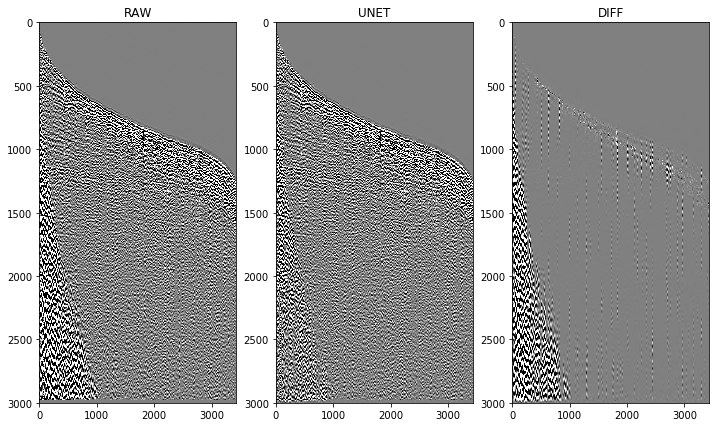

In [57]:
cv = 0.2
fig, ax = plt.subplots(1, 3, figsize=(12, 7))
ax[0].imshow(raw.T, vmin=-cv, vmax=cv, cmap='gray')
ax[1].imshow(res.T, vmin=-cv, vmax=cv, cmap='gray')
ax[2].imshow((res - raw).T, vmin=-cv, vmax=cv, cmap='gray')
ax[0].set_title('RAW')
ax[1].set_title('UNET')
ax[2].set_title('DIFF')
ax[0].axis('auto'), ax[1].axis('auto'), ax[2].axis('auto')
plt.show()

Consider the normalized mean square error:

In [55]:
print('NRMSE =', np.std(res - lift) / np.ptp(lift))

NRMSE = 0.0010855821


The value obtained is in order of magnitude fewer than for raw seismogram:

In [53]:
print('NRMSE =', np.std(raw - lift) / np.ptp(lift))

NRMSE = 0.021289945


However, a more detailed model evaluation is required. 

## Model evaluation

Select a region with ground-rolls in the seismogram and compare Unet and LIFT spectrums:

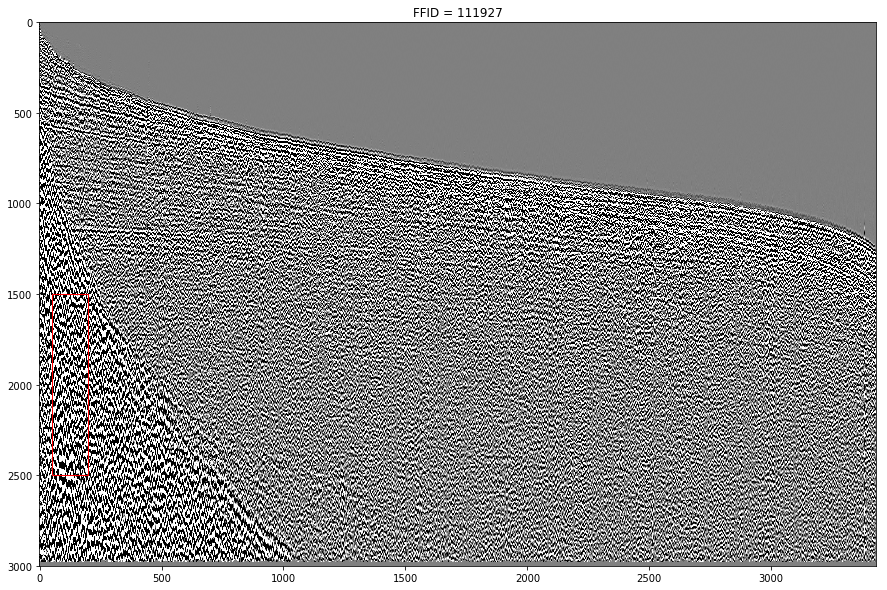

In [19]:
dw = (slice(50, 200), slice(1500, 2500))

plt.figure(figsize=(15, 10))
plt.imshow(raw.T, vmin=-cv, vmax=cv, cmap='gray')
rect = patches.Rectangle((dw[0].start, dw[1].start),
                         dw[0].stop - dw[0].start, dw[1].stop - dw[1].start,
                         linewidth=1, edgecolor='r', facecolor='none')
plt.axes().add_patch(rect)
plt.axes().set_aspect('auto')
plt.title("FFID = {}".format(batch.indices[0]))
plt.show()

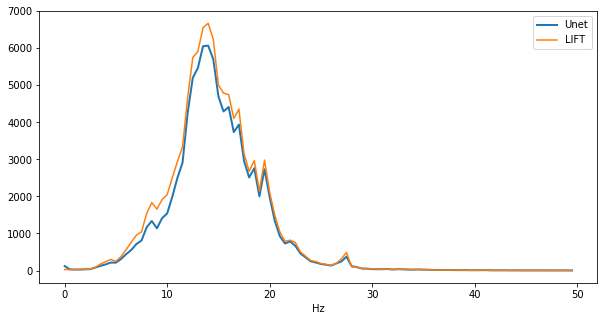

In [20]:
spec_ml = abs(np.fft.rfft(res[dw], axis=1))**2
spec_lift = abs(np.fft.rfft(lift[dw], axis=1))**2
freqs = np.fft.rfftfreq(len(lift[dw][0]), d=0.002)

ds = freqs < 50
plt.figure(figsize=(10, 5))
plt.plot(freqs[ds], np.mean(spec_ml, axis=0)[ds], label='Unet', lw=2)
plt.plot(freqs[ds], np.mean(spec_lift, axis=0)[ds], label='LIFT')
plt.xlabel('Hz')
plt.legend()
plt.show()

Select a region without ground-rolls in the seismogram and compare Unet and LIFT spectrums:

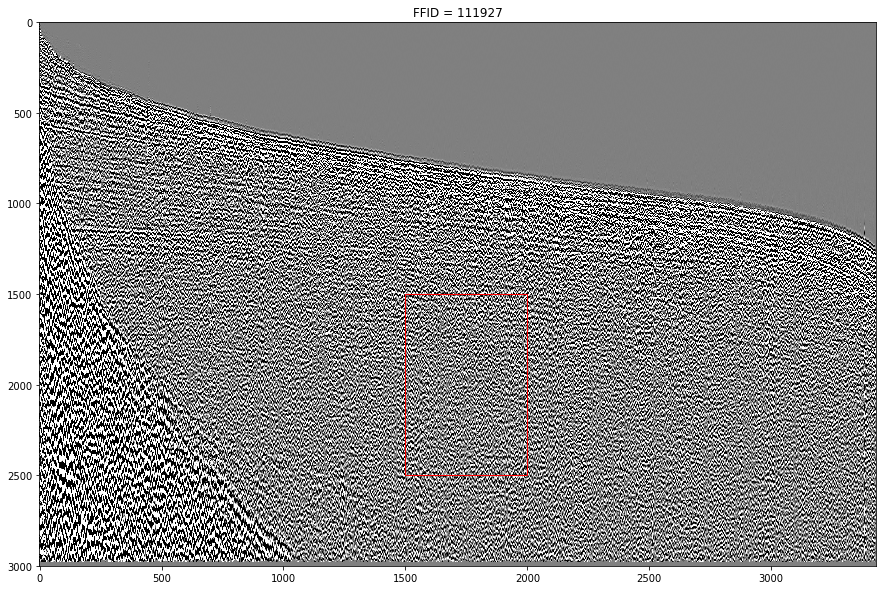

In [21]:
dw =(slice(1500, 2000), slice(1500, 2500))

cv = 0.1
plt.figure(figsize=(15, 10))
plt.imshow(raw.T, vmin=-cv, vmax=cv, cmap='gray')
rect = patches.Rectangle((dw[0].start, dw[1].start),
                         dw[0].stop - dw[0].start, dw[1].stop - dw[1].start,
                         linewidth=1, edgecolor='r', facecolor='none')
plt.axes().add_patch(rect)
plt.axes().set_aspect('auto')
plt.title("FFID = {}".format(batch.indices[0]))
plt.show()

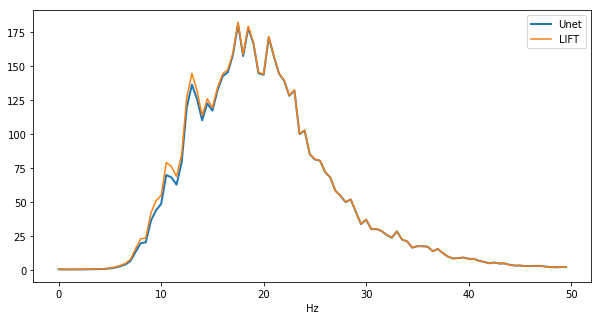

In [22]:
spec_ml = abs(np.fft.rfft(res[dw], axis=1))**2
spec_lift = abs(np.fft.rfft(lift[dw], axis=1))**2

ds = freqs < 50
plt.figure(figsize=(10, 5))
plt.plot(freqs[ds], np.mean(spec_ml, axis=0)[ds], label='Unet', lw=2)
plt.plot(freqs[ds], np.mean(spec_lift, axis=0)[ds], label='LIFT')
plt.xlabel('Hz')
plt.legend()
plt.show()

## Inference on a large dataset

An inference pipeline with dump action:

In [81]:
model_config = {
    "build": False,
    "load": {"path": './unet_model'},
}

def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1)}}

def unstack_results(batch, arr):
    indices = np.cumsum([len(x) for x in batch.raw[:-1]])
    return np.array(np.split(arr, indices) + [None])[:-1]

dpath = '/notebooks/egor/geolog/notebooks/dumps'

predict_pipeline = (Pipeline()
                    .load(components='raw', tslice=np.arange(3000))
#                     .import_model('unet', train_pipeline)
                    .init_model("static", UNet, 'unet', config=model_config)
                    .init_variable('res')
                    .init_variable('count', init_on_each_run=0)
                    .predict_model('unet', fetches='predictions', 
                                   make_data=make_data, save_to=V('res'))
                    .call(unstack_results, arr=V('res'), save_to=B('raw'))
                    .dump_segy(path=F(lambda _, x: os.path.join(dpath, str(x) + '.sgy'), V('count')),
                               src='raw', split=False)
                    .update_variable('count', F(lambda _, x: x + 1, V('count')))
                   )

Run inference on the whole dataset:

In [79]:
batch_size = 7000
predict_pipeline = predict_pipeline << Dataset(TraceIndex(index), SeismicBatch)
predict_pipeline.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

Merge the output files into a single segy file:

In [80]:
stack_index = SegyFilesIndex(name='raw', extra_headers=['offset'],
                             path=os.path.join(dpath, '*.sgy'))

(Dataset(stack_index, SeismicBatch)
 .next_batch(len(stack_index))
 .merge_segy_files(path=os.path.join(dpath, 'merged.sgy'), component='raw'))

## Conclusion

Unet noise attenuation model provides reasonable results. Unet signal spectrum is close to LIFT signal spectrum in different regions of seismograms.